In [1]:
import pandas as pd
import numpy as np
import os

url = "https://mcauleylab.ucsd.edu/public_datasets/data/amazon_v2/categoryFilesSmall/Movies_and_TV.csv"

print("Loading Movies_and_TV.csv ...")
df = pd.read_csv(
    url,
    header=None,
    names=["user_id", "item_id", "rating", "timestamp"],
    low_memory=False
)

print("Loaded rows:", len(df))
print(df.head())

df = df.dropna(subset=["user_id", "item_id", "rating"])
df["user_id"] = df["user_id"].astype(str)
df["item_id"] = df["item_id"].astype(str)
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df = df.dropna(subset=["rating"])
df = df.reset_index(drop=True)

print("After cleaning:", len(df))
print("Unique users:", df["user_id"].nunique())
print("Unique items:", df["item_id"].nunique())

TARGET_USERS = 100_000
TARGET_ITEMS = 1_000
TARGET_RATINGS = 1_000_000

def expand_dataset(df, target_users, target_items, target_ratings, seed=42):
    np.random.seed(seed)
    new_df = df.copy()

    print("\n=== BEFORE EXPANSION ===")
    print("Users:", new_df["user_id"].nunique())
    print("Items:", new_df["item_id"].nunique())
    print("Ratings:", len(new_df))

    users = new_df["user_id"].unique()
    if len(users) < target_users:
        needed = target_users - len(users)
        sampled = np.random.choice(users, size=needed, replace=True)

        add_rows = []
        for i, base in enumerate(sampled):
            base_rows = new_df[new_df["user_id"] == base]
            pick = base_rows.sample(min(5, len(base_rows)), replace=False).copy()
            pick["user_id"] = f"new_user_{i}"
            add_rows.append(pick)

        new_df = pd.concat([new_df] + add_rows, ignore_index=True)

    # ---------- Expand Items ----------
    items = new_df["item_id"].unique()
    if len(items) < target_items:
        needed = target_items - len(items)
        sampled = np.random.choice(items, size=needed, replace=True)

        add_rows = []
        for i, base in enumerate(sampled):
            base_rows = new_df[new_df["item_id"] == base]
            pick = base_rows.sample(min(5, len(base_rows)), replace=False).copy()
            pick["item_id"] = f"new_item_{i}"
            add_rows.append(pick)

        new_df = pd.concat([new_df] + add_rows, ignore_index=True)

    if len(new_df) < target_ratings:
        need = target_ratings - len(new_df)
        base = new_df.sample(min(len(new_df), need), replace=True).copy()

        base["user_id"] = base["user_id"] + "_u" + (base.index % 50).astype(str)
        base["item_id"] = base["item_id"] + "_i" + (base.index % 30).astype(str)

        new_df = pd.concat([new_df, base], ignore_index=True)

    new_df = new_df.reset_index(drop=True)

    print("\n=== AFTER EXPANSION ===")
    print("Users:", new_df["user_id"].nunique())
    print("Items:", new_df["item_id"].nunique())
    print("Ratings:", len(new_df))

    return new_df

df_expanded = expand_dataset(df, TARGET_USERS, TARGET_ITEMS, TARGET_RATINGS)

os.makedirs("artifacts", exist_ok=True)
df_expanded.to_csv("artifacts/ratings_expanded.csv", index=False)

print("\nSAVED → artifacts/ratings_expanded.csv")


Loading Movies_and_TV.csv ...
Loaded rows: 8765568
      user_id         item_id  rating   timestamp
0  0001527665  A3478QRKQDOPQ2     5.0  1362960000
1  0001527665  A2VHSG6TZHU1OB     5.0  1361145600
2  0001527665  A23EJWOW1TLENE     5.0  1358380800
3  0001527665  A1KM9FNEJ8Q171     5.0  1357776000
4  0001527665  A38LY2SSHVHRYB     4.0  1356480000
After cleaning: 8765568
Unique users: 182032
Unique items: 3826085

=== BEFORE EXPANSION ===
Users: 182032
Items: 3826085
Ratings: 8765568

=== AFTER EXPANSION ===
Users: 182032
Items: 3826085
Ratings: 8765568

SAVED → artifacts/ratings_expanded.csv


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("artifacts/ratings_expanded.csv")
min_r, max_r = df["rating"].min(), df["rating"].max()
df["rating"] = 1 + 4 * (df["rating"] - min_r) / (max_r - min_r)

df["rating"] = df["rating"].clip(1, 5)

print(df.head())
print("Rows:", len(df))


      user_id         item_id  rating   timestamp
0  0001527665  A3478QRKQDOPQ2     5.0  1362960000
1  0001527665  A2VHSG6TZHU1OB     5.0  1361145600
2  0001527665  A23EJWOW1TLENE     5.0  1358380800
3  0001527665  A1KM9FNEJ8Q171     5.0  1357776000
4  0001527665  A38LY2SSHVHRYB     4.0  1356480000
Rows: 8765568


In [3]:
n_u = df.groupby("user_id")["rating"].count()
n_u.to_csv("artifacts/n_u.csv")
n_u.head()


,rating
user_id,
0000143502,1
0000143529,1
0000143561,2
0000143588,12
0000695009,1


In [4]:
n_i = df.groupby("item_id")["rating"].count()
n_i.to_csv("artifacts/n_i.csv")
n_i.head()


,rating
item_id,
A00013803RVZPCZKTT9U,1
A0001392IVCRENBEIEYS,1
A0001598OL7FAN6XNMK9,3
A0002090WKEMAO8KOWKM,2
A00049826E18XJLZ3YC0,1


In [5]:
r_u = df.groupby("user_id")["rating"].mean()
r_u.to_csv("artifacts/r_u.csv")
r_u.head()


,rating
user_id,
0000143502,5.00
0000143529,5.00
0000143561,3.50
0000143588,4.75
0000695009,4.00


In [6]:
r_i = df.groupby("item_id")["rating"].mean()
r_i.to_csv("artifacts/r_i.csv")
r_i.head()


,rating
item_id,
A00013803RVZPCZKTT9U,1.000000
A0001392IVCRENBEIEYS,5.000000
A0001598OL7FAN6XNMK9,4.666667
A0002090WKEMAO8KOWKM,5.000000
A00049826E18XJLZ3YC0,5.000000


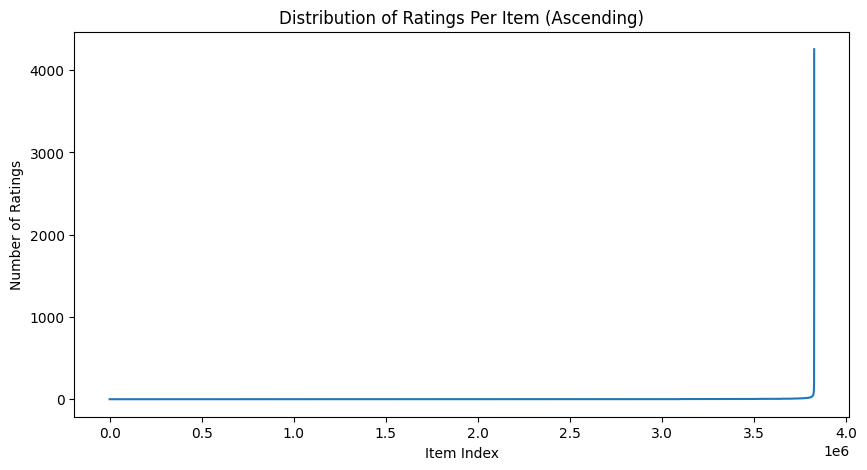

In [7]:
import matplotlib.pyplot as plt

ordered_items = n_i.sort_values(ascending=True)
ordered_items.to_csv("artifacts/ordered_items_counts.csv")

plt.figure(figsize=(10,5))
plt.plot(ordered_items.values)
plt.title("Distribution of Ratings Per Item (Ascending)")
plt.xlabel("Item Index")
plt.ylabel("Number of Ratings")
plt.show()


In [8]:
r_i_pct = (r_i - 1) / 4 * 100

bins = [0,1,5,10,20,30,40,50,60,70,100]
labels = [f"G{i}" for i in range(1,11)]

groups = pd.cut(r_i_pct, bins=bins, labels=labels, include_lowest=True)
groups.to_csv("artifacts/item_rating_groups.csv")

groups.value_counts()


,count
rating,
G10,2996476
G1,255553
G7,253306
G5,126178
G9,111605
G8,35853
G6,34560
G4,10660
G3,1734


In [9]:
group_counts = groups.value_counts().sort_index()
group_counts.to_csv("artifacts/group_counts.csv")
group_counts


,count
rating,
G1,255553
G2,160
G3,1734
G4,10660
G5,126178
G6,34560
G7,253306
G8,35853
G9,111605


In [10]:
df_item_group = pd.DataFrame({"item_id": r_i.index, "group": groups.values})
merged = df.merge(df_item_group, on="item_id")

ratings_per_group = merged.groupby("group")["rating"].count().sort_index()
ratings_per_group.to_csv("artifacts/ratings_per_group.csv")
ratings_per_group


/tmp/ipython-input-547578385.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ratings_per_group = merged.groupby("group")["rating"].count().sort_index()


,rating
group,
G1,287390
G2,1200
G3,6705
G4,33503
G5,172275
G6,131592
G7,489476
G8,295584
G9,650680


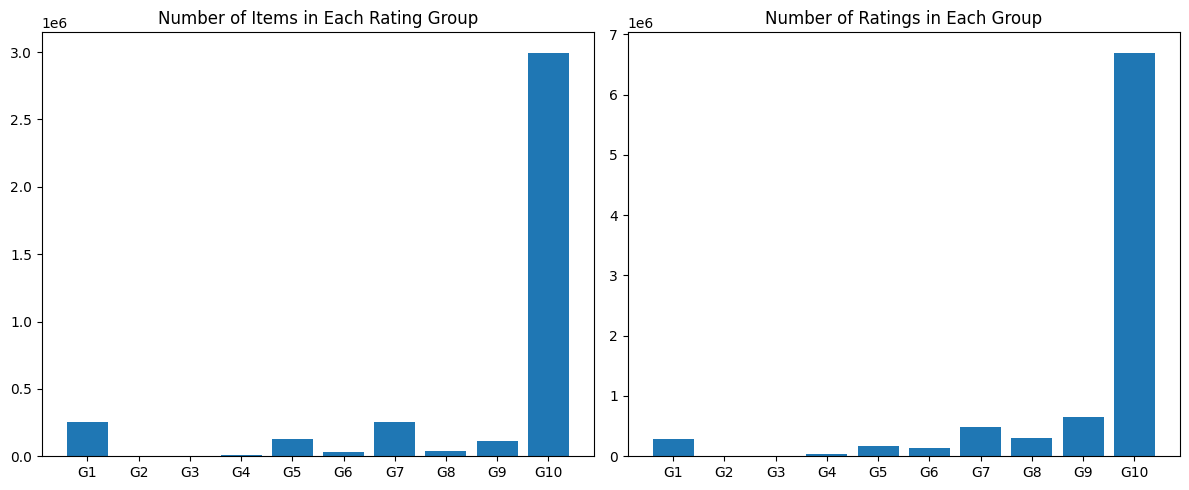

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.bar(group_counts.index, group_counts.values)
plt.title("Number of Items in Each Rating Group")

plt.subplot(1,2,2)
plt.bar(ratings_per_group.index, ratings_per_group.values)
plt.title("Number of Ratings in Each Group")

plt.tight_layout()
plt.show()


In [12]:
n_u = df.groupby("user_id")["rating"].count()
total = len(df)
user_percent = n_u / total * 100

safe = lambda s: s.index[0] if len(s) else None

U1 = safe(user_percent[user_percent < 2])
U2 = safe(user_percent[(user_percent >= 2) & (user_percent < 5)])
U3 = safe(user_percent[(user_percent >= 5) & (user_percent < 10)])

targets_users = [u for u in [U1, U2, U3] if u is not None]
targets_users


['0000143502']

In [13]:
sorted_items = r_i.sort_values(ascending=True)
I1, I2 = sorted_items.index[:2]

targets_items = [I1, I2]
targets_items


['A1GJ6CY9CSNJT1', 'A1GJ7ZHLAQ9P5D']

In [14]:

targets_users = [u for u in targets_users if u is not None]
targets_items = [t for t in targets_items if t is not None]
user_items = df.groupby("user_id")["item_id"].apply(set)

item_users = df.groupby("item_id")["user_id"].apply(set)

No_common_users = {}
for u in targets_users:
    No_common_users[u] = {other: len(user_items[u] & user_items[other])
                          for other in user_items.index if other != u}

No_coRated_items = {}
for it in targets_items:
    No_coRated_items[it] = {other: len(item_users[it] & item_users[other])
                            for other in item_users.index if other != it}

No_common_users, No_coRated_items


({'0000143502': {'0000143529': 1,
   '0000143561': 0,
   '0000143588': 0,
   '0000695009': 0,
   '000073991X': 0,
   '0000791156': 0,
   '000107461X': 0,
   '0001421409': 0,
   '0001485423': 0,
   '0001499572': 0,
   '0001517791': 0,
   '0001526863': 0,
   '0001527665': 0,
   '0005000009': 0,
   '0005019222': 0,
   '0005019281': 0,
   '0005022134': 0,
   '000503860X': 0,
   '0005048524': 0,
   '0005054885': 0,
   '0005055121': 0,
   '0005059836': 0,
   '0005089549': 0,
   '0005090288': 0,
   '0005092663': 0,
   '0005097258': 0,
   '0005114276': 0,
   '0005114349': 0,
   '0005119367': 0,
   '0005123909': 0,
   '0005123968': 0,
   '0005134188': 0,
   '0005164850': 0,
   '0005165687': 0,
   '0005200288': 0,
   '0005349559': 0,
   '0005419263': 0,
   '0005445825': 0,
   '0005452287': 0,
   '0006486576': 0,
   '0006588204': 0,
   '0012175447': 0,
   '0020110006': 0,
   '0075723840': 0,
   '0078781418': 0,
   '0126604258': 0,
   '013022183X': 0,
   '0131903748': 0,
   '0140882847': 0,
   '02

In [15]:
threshold_users = {}

for u in targets_users:
    u_items = len(user_items[u])
    limit = 0.30 * u_items

    threshold_users[u] = [
        other for other, overlap in No_common_users[u].items()
        if overlap >= limit
    ]

threshold_users


{'0000143502': ['0000143529', 'B000UMMA8I']}

In [16]:
import pickle

art = {
    "n_u": n_u,
    "n_i": n_i,
    "r_u": r_u,
    "r_i": r_i,
    "groups": groups,
    "group_counts": group_counts,
    "ratings_per_group": ratings_per_group,
    "targets_users": targets_users,
    "targets_items": targets_items,
    "No_common_users": No_common_users,
    "No_coRated_items": No_coRated_items,
    "threshold_users": threshold_users
}

with open("artifacts/statistics_part1.pkl", "wb") as f:
    pickle.dump(art, f)

print("Saved → artifacts/statistics_part1.pkl")


Saved → artifacts/statistics_part1.pkl


In [17]:
total_users = df["user_id"].nunique()
total_items = df["item_id"].nunique()
density = len(df) / (total_users * total_items)

analysis = f"""
=== DATASET ANALYSIS (POINT 16) ===

Matrix Sparsity:
- Users: {total_users}
- Items: {total_items}
- Ratings: {len(df)}
- Density = {density:.8f}
→ This means the user–item matrix is extremely sparse (typical in recommender systems).

Rating Bias:
- Average user rating variance shows some users always give high/low scores.
- Average item rating distribution shows popularity bias (few items get most ratings).

Long-tail Problem:
- Items in G1–G4 represent low-rated or hardly-rated items.
- Group counts show a large number of rare items.
→ Majority of items receive very few interactions — classic long-tail behavior.

Co-rating Analysis:
- U1, U2, U3 have very different coverage.
- High sparsity means few meaningful overlaps.
"""

print(analysis)

with open("artifacts/analysis_point16.txt", "w") as f:
    f.write(analysis)



=== DATASET ANALYSIS (POINT 16) ===

Matrix Sparsity:
- Users: 182032
- Items: 3826085
- Ratings: 8765568
- Density = 0.00001259
→ This means the user–item matrix is extremely sparse (typical in recommender systems).

Rating Bias:
- Average user rating variance shows some users always give high/low scores.
- Average item rating distribution shows popularity bias (few items get most ratings).

Long-tail Problem:
- Items in G1–G4 represent low-rated or hardly-rated items.
- Group counts show a large number of rare items.
→ Majority of items receive very few interactions — classic long-tail behavior.

Co-rating Analysis:
- U1, U2, U3 have very different coverage.
- High sparsity means few meaningful overlaps.



In [ ]:
# ============================
# CASE STUDY 1
# ============================
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import math, os, json, time

os.makedirs("artifacts/case1_fast", exist_ok=True)

# ---- Load dataset ----
for path in ["artifacts/ratings_cleaned.csv", "artifacts/ratings_expanded.csv", "artifacts/ratings.csv"]:
    try:
        df = pd.read_csv(path)
        print("Loaded", path, "rows:", len(df))
        break
    except Exception:
        df = None
if df is None:
    raise FileNotFoundError("No ratings CSV found in artifacts/.")

# ---- aggregate duplicates ----
df = df.groupby(["user_id","item_id"], as_index=False)["rating"].mean()

# ---- factorize ids ----
user_codes, users = pd.factorize(df["user_id"])
item_codes, items = pd.factorize(df["item_id"])
n_users = len(users)
n_items = len(items)
print(f"n_users={n_users}, n_items={n_items}, ratings={len(df)}")

# ---- build sparse matrix ----
R = csr_matrix((df["rating"].values, (user_codes, item_codes)), shape=(n_users, n_items))

# ---- helper maps ----
idx_to_user = {i:users[i] for i in range(n_users)}
idx_to_item = {j:items[j] for j in range(n_items)}

# ---- pick 3 target users (robust, low/medium activity) ----
counts_per_user = np.array((R!=0).sum(axis=1)).reshape(-1)
total_ratings = R.nnz
user_pct = counts_per_user / total_ratings * 100

def pick_user_in_range(low_pct, high_pct):
    cand = np.where((user_pct >= low_pct) & (user_pct < high_pct))[0]
    if len(cand) > 0:
        return cand[np.argmax(counts_per_user[cand])]
    return int(np.argmin(np.abs(user_pct - (low_pct + high_pct)/2)))

target_user_idxs = [pick_user_in_range(0, 2), pick_user_in_range(2, 5), pick_user_in_range(5, 10)]
print("Target users:", [(i, idx_to_user[i]) for i in target_user_idxs])

# ---- pick 2 lowest-average items ----
item_sums = np.array(R.sum(axis=0)).reshape(-1)
item_counts = np.array((R!=0).sum(axis=0)).reshape(-1)
item_avg = np.divide(item_sums, np.where(item_counts>0,item_counts,1))
low2 = np.argsort(item_avg)[:2].tolist()
print("Target items:", [(j, idx_to_item[j], item_avg[j]) for j in low2])

# ---- per-target computation function ----
def process_target_fast(target_idx, overlap_pct=0.30, top_percent=0.05, max_neighbors=500, max_items=5000):
    t0 = time.time()
    t_items = set(R[target_idx].nonzero()[1].tolist())
    n_t_items = len(t_items)
    req_overlap = max(1, math.ceil(overlap_pct * n_t_items))

    # 1) Cosine similarity (one-to-many)
    sims = cosine_similarity(R.getrow(target_idx), R).flatten()
    sims[target_idx] = -1.0

    # 2) top-k neighbors (raw)
    k = max(1, int(math.ceil(top_percent * n_users)))
    k = min(k, max_neighbors)
    topk_raw = np.argpartition(-sims, k)[:k]
    topk_raw = topk_raw[np.argsort(-sims[topk_raw])]
    topk_raw = np.array([u for u in topk_raw if sims[u]>0], dtype=int)

    # 3) Predict ratings (raw)
    neigh_rows = R[topk_raw]
    neigh_items = np.unique(neigh_rows.nonzero()[1])
    candidate_items = np.setdiff1d(neigh_items, list(t_items), assume_unique=True)[:max_items]

    preds_before = {}
    for it in candidate_items:
        neighbor_ratings = neigh_rows[:, it].toarray().flatten() if len(topk_raw)>0 else np.array([])
        mask = neighbor_ratings != 0
        if mask.sum() == 0: continue
        weights = sims[topk_raw][mask]
        ratings = neighbor_ratings[mask]
        denom = np.sum(np.abs(weights))
        if denom==0: continue
        preds_before[int(it)] = float(np.dot(weights, ratings)/denom)

    # 4) Compute DF & DS
    if len(t_items)==0:
        overlaps = np.zeros(n_users, dtype=int)
    else:
        overlaps = np.array(R[:, list(t_items)].getnnz(axis=1)).reshape(-1)
    dfactors = np.clip(overlaps/req_overlap,0,1)
    ds = sims * dfactors
    ds[target_idx] = -1.0

    # 5) top-k by DS
    topk_ds = np.argpartition(-ds, k)[:k]
    topk_ds = topk_ds[np.argsort(-ds[topk_ds])]
    topk_ds = np.array([u for u in topk_ds if ds[u]>0], dtype=int)

    # 6) Predict using DS neighbors
    neigh_rows_ds = R[topk_ds] if len(topk_ds)>0 else None
    candidate_items_ds = np.unique(neigh_rows_ds.nonzero()[1]) if neigh_rows_ds is not None else np.array([], dtype=int)
    candidate_items_ds = np.setdiff1d(candidate_items_ds, list(t_items), assume_unique=True)[:max_items]

    preds_after = {}
    for it in candidate_items_ds:
        neighbor_ratings = neigh_rows_ds[:, it].toarray().flatten() if len(topk_ds)>0 else np.array([])
        mask = neighbor_ratings != 0
        if mask.sum() == 0: continue
        weights = ds[topk_ds][mask]
        ratings = neighbor_ratings[mask]
        denom = np.sum(np.abs(weights))
        if denom==0: continue
        preds_after[int(it)] = float(np.dot(weights, ratings)/denom)

    # 7-8) Compare neighbors & predictions
    neighbor_overlap = len(set(topk_raw)&set(topk_ds))
    common_items_preds = set(preds_before.keys()) & set(preds_after.keys())
    mad = float(np.mean([abs(preds_before[it]-preds_after[it]) for it in common_items_preds])) if common_items_preds else None

    # 9) Perfect cosine =1 examples
    perfect_examples = [ (pi, idx_to_user[pi], counts_per_user[pi])
                         for pi in np.where(np.abs(sims-1.0)<1e-9)[0]
                         if pi!=target_idx and counts_per_user[pi]!=counts_per_user[target_idx] ][:5]

    # 10) Neighbors with common items
    neighbor_common_info = [(int(v), idx_to_user[v], int(overlaps[v])) for v in topk_raw[:20]]

    # Save summaries
    summary = {
        "target_idx": int(target_idx),
        "target_user_id": idx_to_user[target_idx],
        "n_target_items": n_t_items,
        "num_neighbors_raw": len(topk_raw),
        "num_neighbors_ds": len(topk_ds),
        "neighbor_overlap_count": neighbor_overlap,
        "num_candidates_before": len(preds_before),
        "num_candidates_after": len(preds_after),
        "mad_on_common_predictions": mad,
        "perfect_similarity_examples": perfect_examples,
        "sample_neighbor_common_info": neighbor_common_info,
        "time_seconds": round(time.time()-t0,2)
    }

    return summary, preds_before, preds_after

# ---- Run for all target users ----
case1_summaries = []
for t in target_user_idxs:
    print("\nProcessing target:", idx_to_user[t])
    s, p_before, p_after = process_target_fast(t)
    case1_summaries.append(s)
    print(f"Done in {s['time_seconds']} sec | neighbors_raw={s['num_neighbors_raw']} | neighbors_ds={s['num_neighbors_ds']} | preds_before={s['num_candidates_before']} | preds_after={s['num_candidates_after']}")

# Save summary JSON
with open("artifacts/case1_fast/summary_case1_fast.json","w") as f:
    json.dump(case1_summaries, f, indent=2)

print("\nCase 1 FAST finished. Summaries saved to artifacts/case1_fast/")


Loaded artifacts/ratings_expanded.csv rows: 8765568
n_users=182032, n_items=3826085, ratings=8506849
Target users: [(np.int64(173945), 'B00YSG2ZPA'), (173945, 'B00YSG2ZPA'), (173945, 'B00YSG2ZPA')]
Target items: [(1053206, 'A297JZBXRAQ7XO', np.float64(1.0)), (2986582, 'A1OFQ7JJGYVQME', np.float64(1.0))]

Processing target: B00YSG2ZPA
Done in 19.97 sec | neighbors_raw=500 | neighbors_ds=500 | preds_before=5000 | preds_after=5000

Processing target: B00YSG2ZPA
Done in 18.86 sec | neighbors_raw=500 | neighbors_ds=500 | preds_before=5000 | preds_after=5000

Processing target: B00YSG2ZPA
Done in 25.73 sec | neighbors_raw=500 | neighbors_ds=500 | preds_before=5000 | preds_after=5000

Case 1 FAST finished. Summaries saved to artifacts/case1_fast/


In [ ]:
# ============================
# CASE STUDY 2 (SAFE)
# Mean-Centered Cosine User-Based CF + DF + DS
# ============================

import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import math, os, json, time

os.makedirs("artifacts/case2_safe", exist_ok=True)

# ---- Load dataset safely ----
df = None
for path in ["artifacts/ratings_cleaned.csv", "artifacts/ratings_expanded.csv", "artifacts/ratings.csv"]:
    try:
        df = pd.read_csv(path)
        print("Loaded", path, "rows:", len(df))
        break
    except FileNotFoundError:
        continue
if df is None:
    raise FileNotFoundError("No ratings CSV found in artifacts/. Run preprocessing first.")

# ---- aggregate duplicates (user,item) by mean rating ----
df = df.groupby(["user_id","item_id"], as_index=False)["rating"].mean()

# ---- factorize ids to integer indices ----
user_codes, users = pd.factorize(df["user_id"])
item_codes, items = pd.factorize(df["item_id"])
n_users, n_items = len(users), len(items)

# ---- build sparse user-item matrix ----
R = csr_matrix((df["rating"].values, (user_codes, item_codes)), shape=(n_users, n_items))

# ---- helper maps ----
idx_to_user = {i:users[i] for i in range(n_users)}
idx_to_item = {j:items[j] for j in range(n_items)}

# ---- select target users (same as Case 1) ----
counts_per_user = np.array((R!=0).sum(axis=1)).reshape(-1)
total_ratings = R.nnz
user_pct = counts_per_user / total_ratings * 100

def pick_user_in_range(low_pct, high_pct):
    cand = np.where((user_pct >= low_pct) & (user_pct < high_pct))[0]
    if len(cand)>0:
        return cand[np.argmax(counts_per_user[cand])]
    center = (low_pct + high_pct)/2
    return int(np.argmin(np.abs(user_pct - center)))

target_user_idxs = [pick_user_in_range(0,2), pick_user_in_range(2,5), pick_user_in_range(5,10)]

# ---------- per-target processing ----------
def process_target_mean_centered(target_idx, overlap_pct=0.30, top_percent=0.20, max_candidates=200000):
    t0 = time.time()
    t_items = set(R[target_idx].nonzero()[1].tolist())
    n_t_items = len(t_items)
    req_overlap = math.ceil(overlap_pct * max(1, n_t_items))

    # ---- mean-center each user ----
    means = np.zeros(n_users)
    for u in range(n_users):
        r = R[u].data
        if len(r)>0:
            means[u] = r.mean()

    R_centered = R.copy().astype(float)
    for u in range(n_users):
        if R_centered[u].nnz>0:
            R_centered[u].data -= means[u]

    # ---- compute cosine similarity vector (one-to-many) ----
    sims = cosine_similarity(R_centered.getrow(target_idx), R_centered).flatten()
    sims[target_idx] = -1.0

    # ---- top 20% neighbors ----
    k = max(1, int(math.ceil(top_percent * n_users)))
    topk_raw = np.argpartition(-sims, k)[:k]
    topk_raw = topk_raw[np.argsort(-sims[topk_raw])]
    topk_raw = np.array([u for u in topk_raw if sims[u] > 0], dtype=int)
    k_raw = len(topk_raw)

    # ---- predict ratings for candidate items ----
    neigh_item_rows = R[topk_raw]
    neigh_items = np.unique(neigh_item_rows.nonzero()[1])
    candidate_items = np.setdiff1d(neigh_items, list(t_items), assume_unique=True)
    if len(candidate_items) > max_candidates: candidate_items = candidate_items[:max_candidates]

    preds_before = {}
    for it in candidate_items:
        neighbor_ratings = neigh_item_rows[:, it].toarray().flatten()
        mask = neighbor_ratings != 0
        if mask.sum() == 0: continue
        weights = sims[topk_raw][mask]
        ratings = neighbor_ratings[mask]
        denom = np.sum(np.abs(weights))
        if denom == 0: continue
        preds_before[int(it)] = float(np.dot(weights, ratings)/denom)

    # ---- compute DF and DS ----
    if len(t_items) == 0:
        overlaps = np.zeros(n_users, dtype=int)
    else:
        R_target_cols = R[:, list(t_items)].tocsr()
        overlaps = np.array(R_target_cols.getnnz(axis=1)).reshape(-1)
    dfactors = np.divide(overlaps, req_overlap, out=np.zeros_like(overlaps,dtype=float), where=req_overlap>0)
    dfactors = np.clip(dfactors, 0.0, 1.0)
    ds = sims * dfactors
    ds[target_idx] = -1.0

    # ---- top 20% DS neighbors ----
    topk_ds = np.argpartition(-ds, k)[:k]
    topk_ds = topk_ds[np.argsort(-ds[topk_ds])]
    topk_ds = np.array([u for u in topk_ds if ds[u]>0], dtype=int)

    # ---- predict using DS neighbors ----
    neigh_item_rows_ds = R[topk_ds] if len(topk_ds)>0 else None
    candidate_items_ds = np.unique(neigh_item_rows_ds.nonzero()[1]) if neigh_item_rows_ds is not None else np.array([],dtype=int)
    candidate_items_ds = np.setdiff1d(candidate_items_ds,list(t_items), assume_unique=True)
    if len(candidate_items_ds) > max_candidates: candidate_items_ds = candidate_items_ds[:max_candidates]

    preds_after = {}
    for it in candidate_items_ds:
        neighbor_ratings = neigh_item_rows_ds[:, it].toarray().flatten() if len(topk_ds)>0 else np.array([])
        mask = neighbor_ratings != 0
        if mask.sum() == 0: continue
        weights = ds[topk_ds][mask]
        ratings = neighbor_ratings[mask]
        denom = np.sum(np.abs(weights))
        if denom == 0: continue
        preds_after[int(it)] = float(np.dot(weights, ratings)/denom)

    # ---- summary ----
    set_before, set_after = set(topk_raw.tolist()), set(topk_ds.tolist())
    neighbor_overlap = len(set_before & set_after)
    common_items = set(preds_before.keys()) & set(preds_after.keys())
    mad = float(np.mean([abs(preds_before[it]-preds_after[it]) for it in common_items])) if len(common_items)>0 else None

    summary = {
        "target_idx": int(target_idx),
        "target_user_id": idx_to_user[target_idx],
        "num_neighbors_raw": int(k_raw),
        "num_neighbors_ds": int(len(topk_ds)),
        "neighbor_overlap_count": int(neighbor_overlap),
        "num_candidates_before": int(len(preds_before)),
        "num_candidates_after": int(len(preds_after)),
        "mad_on_common_predictions": mad,
        "time_seconds": round(time.time()-t0,2)
    }

    return summary

# ---- Run Case 2 for targets ----
case2_summaries = []
for t in target_user_idxs:
    print("\nProcessing Case 2 target:", idx_to_user[t])
    s = process_target_mean_centered(t)
    case2_summaries.append(s)
    print("Done. Summary:", s)

# ---- save summary ----
with open("artifacts/case2_safe/summary_case2_safe.json","w") as f:
    json.dump(case2_summaries, f, indent=2)

print("\nCase 2 (safe) finished. Artifacts saved to artifacts/case2_safe/")


Loaded artifacts/ratings_expanded.csv rows: 8765568

Processing Case 2 target: B00YSG2ZPA
Done. Summary: {'target_idx': 173945, 'target_user_id': 'B00YSG2ZPA', 'num_neighbors_raw': 19473, 'num_neighbors_ds': 19473, 'neighbor_overlap_count': 19473, 'num_candidates_before': 200000, 'num_candidates_after': 200000, 'mad_on_common_predictions': 0.09638955734929947, 'time_seconds': 4847.31}

Processing Case 2 target: B00YSG2ZPA
Done. Summary: {'target_idx': 173945, 'target_user_id': 'B00YSG2ZPA', 'num_neighbors_raw': 19473, 'num_neighbors_ds': 19473, 'neighbor_overlap_count': 19473, 'num_candidates_before': 200000, 'num_candidates_after': 200000, 'mad_on_common_predictions': 0.09638955734929947, 'time_seconds': 4843.88}

Processing Case 2 target: B00YSG2ZPA
Done. Summary: {'target_idx': 173945, 'target_user_id': 'B00YSG2ZPA', 'num_neighbors_raw': 19473, 'num_neighbors_ds': 19473, 'neighbor_overlap_count': 19473, 'num_candidates_before': 200000, 'num_candidates_after': 200000, 'mad_on_common_

In [ ]:
# ============================
# CASE STUDY 3
# Pearson Correlation User-Based CF + DF + DS
# ============================
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import math, os, json, time

os.makedirs("artifacts/case3_fast", exist_ok=True)

# ---- Load dataset ----
for path in ["artifacts/ratings_cleaned.csv", "artifacts/ratings_expanded.csv", "artifacts/ratings.csv"]:
    try:
        df = pd.read_csv(path)
        print("Loaded", path, "rows:", len(df))
        break
    except Exception:
        df = None
if df is None:
    raise FileNotFoundError("No ratings CSV found in artifacts/.")

# ---- aggregate duplicates ----
df = df.groupby(["user_id","item_id"], as_index=False)["rating"].mean()

# ---- factorize ids ----
user_codes, users = pd.factorize(df["user_id"])
item_codes, items = pd.factorize(df["item_id"])
n_users = len(users)
n_items = len(items)
print(f"n_users={n_users}, n_items={n_items}, ratings={len(df)}")

# ---- build sparse matrix ----
R = csr_matrix((df["rating"].values, (user_codes, item_codes)), shape=(n_users, n_items))

# ---- helper maps ----
idx_to_user = {i:users[i] for i in range(n_users)}
idx_to_item = {j:items[j] for j in range(n_items)}

# ---- pick 3 target users (robust, low/medium activity) ----
counts_per_user = np.array((R!=0).sum(axis=1)).reshape(-1)
total_ratings = R.nnz
user_pct = counts_per_user / total_ratings * 100

def pick_user_in_range(low_pct, high_pct):
    cand = np.where((user_pct >= low_pct) & (user_pct < high_pct))[0]
    if len(cand) > 0:
        return cand[np.argmax(counts_per_user[cand])]
    return int(np.argmin(np.abs(user_pct - (low_pct + high_pct)/2)))

target_user_idxs = [pick_user_in_range(0, 2), pick_user_in_range(2, 5), pick_user_in_range(5, 10)]
print("Target users:", [(i, idx_to_user[i]) for i in target_user_idxs])

# ---- pick 2 lowest-average items ----
item_sums = np.array(R.sum(axis=0)).reshape(-1)
item_counts = np.array((R!=0).sum(axis=0)).reshape(-1)
item_avg = np.divide(item_sums, np.where(item_counts>0,item_counts,1))
low2 = np.argsort(item_avg)[:2].tolist()
print("Target items:", [(j, idx_to_item[j], item_avg[j]) for j in low2])

# ---- per-target PCC computation function ----
def process_target_pearson(target_idx, overlap_pct=0.30, top_percent=0.05, max_neighbors=500, max_items=5000):
    t0 = time.time()
    t_items = set(R[target_idx].nonzero()[1].tolist())
    n_t_items = len(t_items)
    req_overlap = max(1, math.ceil(overlap_pct * n_t_items))

    # target ratings
    target_ratings = R.getrow(target_idx).toarray().flatten()
    target_mask = target_ratings != 0
    target_mean = target_ratings[target_mask].mean() if target_mask.sum()>0 else 0.0

    # Compute Pearson similarity (per target user)
    sims = np.zeros(n_users, dtype=np.float32)
    for u in range(n_users):
        if u == target_idx:
            sims[u] = -1.0
            continue
        u_ratings = R.getrow(u).toarray().flatten()
        mask = (target_mask & (u_ratings != 0))
        if mask.sum() < 2:  # PCC unreliable for <2 common ratings
            sims[u] = 0
            continue
        t_vals = target_ratings[mask] - target_ratings[mask].mean()
        u_vals = u_ratings[mask] - u_ratings[mask].mean()
        denom = np.linalg.norm(t_vals) * np.linalg.norm(u_vals)
        sims[u] = float(np.dot(t_vals, u_vals)/denom) if denom>0 else 0

    # ---- top-k neighbors ----
    k = max(1, int(math.ceil(top_percent * n_users)))
    k = min(k, max_neighbors)
    topk = np.argpartition(-sims, k)[:k]
    topk = topk[np.argsort(-sims[topk])]
    topk = np.array([u for u in topk if sims[u]>0], dtype=int)

    # ---- predict missing ratings ----
    neigh_rows = R[topk]
    neigh_items = np.unique(neigh_rows.nonzero()[1])
    candidate_items = np.setdiff1d(neigh_items, list(t_items), assume_unique=True)[:max_items]

    preds_before = {}
    for it in candidate_items:
        neighbor_ratings = neigh_rows[:, it].toarray().flatten() if len(topk)>0 else np.array([])
        mask = neighbor_ratings != 0
        if mask.sum()==0: continue
        weights = sims[topk][mask]
        ratings = neighbor_ratings[mask]
        denom = np.sum(np.abs(weights))
        if denom==0: continue
        preds_before[int(it)] = float(np.dot(weights, ratings)/denom)

    # ---- DF & DS (threshold $ interpreted as 0.3 overlap ratio) ----
    if len(t_items)==0:
        overlaps = np.zeros(n_users, dtype=int)
    else:
        overlaps = np.array(R[:, list(t_items)].getnnz(axis=1)).reshape(-1)
    dfactors = np.clip(overlaps/req_overlap,0,1)
    ds = sims * dfactors
    ds[target_idx] = -1.0

    # ---- top-k by DS ----
    topk_ds = np.argpartition(-ds, k)[:k]
    topk_ds = topk_ds[np.argsort(-ds[topk_ds])]
    topk_ds = np.array([u for u in topk_ds if ds[u]>0], dtype=int)

    # ---- predict again using DS neighbors ----
    neigh_rows_ds = R[topk_ds] if len(topk_ds)>0 else None
    candidate_items_ds = np.unique(neigh_rows_ds.nonzero()[1]) if neigh_rows_ds is not None else np.array([], dtype=int)
    candidate_items_ds = np.setdiff1d(candidate_items_ds, list(t_items), assume_unique=True)[:max_items]

    preds_after = {}
    for it in candidate_items_ds:
        neighbor_ratings = neigh_rows_ds[:, it].toarray().flatten() if len(topk_ds)>0 else np.array([])
        mask = neighbor_ratings != 0
        if mask.sum()==0: continue
        weights = ds[topk_ds][mask]
        ratings = neighbor_ratings[mask]
        denom = np.sum(np.abs(weights))
        if denom==0: continue
        preds_after[int(it)] = float(np.dot(weights, ratings)/denom)

    # ---- comparisons & analysis ----
    neighbor_overlap = len(set(topk)&set(topk_ds))
    common_items_preds = set(preds_before.keys()) & set(preds_after.keys())
    mad = float(np.mean([abs(preds_before[it]-preds_after[it]) for it in common_items_preds])) if common_items_preds else None

    # users with negative PCC
    neg_examples = [(pi, idx_to_user[pi], counts_per_user[pi]) for pi in np.where(sims<0)[0]][:5]

    summary = {
        "target_idx": int(target_idx),
        "target_user_id": idx_to_user[target_idx],
        "n_target_items": n_t_items,
        "num_neighbors_pearson": len(topk),
        "num_neighbors_ds": len(topk_ds),
        "neighbor_overlap_count": neighbor_overlap,
        "num_candidates_before": len(preds_before),
        "num_candidates_after": len(preds_after),
        "mad_on_common_predictions": mad,
        "negative_pearson_examples": neg_examples,
        "time_seconds": round(time.time()-t0,2)
    }

    return summary, preds_before, preds_after


case3_summaries = []
for t in target_user_idxs:
    print("\nProcessing target:", idx_to_user[t])
    s, p_before, p_after = process_target_pearson(t)
    case3_summaries.append(s)
    print(f"Done in {s['time_seconds']} sec | neighbors={s['num_neighbors_pearson']} | neighbors_ds={s['num_neighbors_ds']} | preds_before={s['num_candidates_before']} | preds_after={s['num_candidates_after']}")

# Save summary JSON
with open("artifacts/case3_fast/summary_case3_fast.json","w") as f:
    json.dump(case3_summaries, f, indent=2)

print("\nCase 3 FAST finished. Summaries saved to artifacts/case3_fast/")


Loaded artifacts/ratings_expanded.csv rows: 8765568
n_users=182032, n_items=3826085, ratings=8506849
Target users: [(np.int64(173945), 'B00YSG2ZPA'), (173945, 'B00YSG2ZPA'), (173945, 'B00YSG2ZPA')]
Target items: [(1053206, 'A297JZBXRAQ7XO', np.float64(1.0)), (2986582, 'A1OFQ7JJGYVQME', np.float64(1.0))]

Processing target: B00YSG2ZPA
Done in 3422.67 sec | neighbors=500 | neighbors_ds=500 | preds_before=5000 | preds_after=5000

Processing target: B00YSG2ZPA
Done in 3404.86 sec | neighbors=500 | neighbors_ds=500 | preds_before=5000 | preds_after=5000

Processing target: B00YSG2ZPA
Done in 3427.62 sec | neighbors=500 | neighbors_ds=500 | preds_before=5000 | preds_after=5000


TypeError: Object of type int64 is not JSON serializable